In [1]:
import sys

import pandas as pd

sys.path.append('scripts/')
import flag_dimensionality_reduction as fdr
from utils import *

sys.path.append('Hands/')
from hand_utils import *

import numpy as np
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt


from geomstats.geometry.pre_shape import PreShapeSpace


class GeomstatsShapeSpace():
    """A simple adapter class which uses pymanopt language for geomstats shape space
    """

    def __init__(self, n, k):
        self._man = PreShapeSpace(m_ambient = n, k_landmarks = k)
        self._man.equip_with_group_action("rotations")
        self._man.equip_with_quotient_structure()

    def dist(self, point_a, point_b):
        return self._man.metric.dist(point_a, point_b)

    def exp(self, base_point, tangent_vector):
        return self._man.metric.exp(tangent_vector, base_point=base_point)

    def log(self, base_point, ambient_point):
        return self._man.to_tangent(ambient_point, base_point=base_point)
    
    def random_point(self):
        return self._man.random_point()


INFO: Using numpy backend


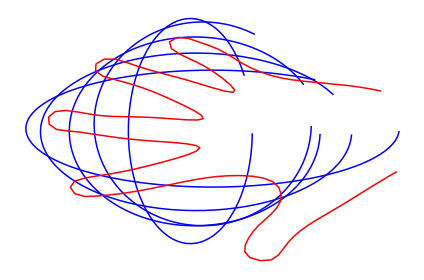

In [2]:
filepath = './Hands/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands = np.array(segmentationlist).T


shapes = []
for h in hands:
    k_shape = unmake_1d(h)
    k_shape = k_shape - np.mean(k_shape, axis = 0)
    k_shape = k_shape/np.linalg.norm(k_shape)
    shapes.append(k_shape)


def generate_ellipse_outlier1(seed: int):
    # np.random.seed(seed)

    # # Generate data points on the ellipse
    # x = np.random.normal(0,10, 56)
    # y = np.random.normal(0,10, 56) 

    
    # pt = np.vstack([x,y]).T

    # pt = pt - np.mean(pt, axis = 0)
    # pt = pt/np.linalg.norm(pt)
    # return pt
    np.random.seed(seed)
    # Define ellipse parameters
    center_x = .1*np.random.normal(0,1)  # X-coordinate of the center #was .1
    center_y = .1*np.random.normal(0,1)  # Y-coordinate of the center #was .1
    major_axis = .4+ np.random.normal(0,.1)#np.random.normal(0,.3) # np.random.normal(0,1)  # Length of the major axis
    minor_axis = .4+ np.random.normal(0,.1)#np.random.normal(0,.3)  #np.random.normal(0,1)   # Length of the minor axis


    # Generate data points on the ellipse
    # theta = np.linspace(-0.2, 1.8*np.pi, 56)  # Create 100 equally spaced points around the ellipse
    theta = np.linspace(.1 + np.random.rand(),2*np.pi, 56)
    x = center_x + major_axis * np.cos(theta)
    y = center_y + minor_axis * np.sin(theta)
    
    pt = np.vstack([x,y]).T

    pt = pt - np.mean(pt, axis = 0)
    pt = pt/np.linalg.norm(pt)
    return pt

for i in range(5):
    outlier = generate_ellipse_outlier1(i)
    interp_points = interp(outlier)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'b')
interp_points = interp(shapes[0])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")

plt.tight_layout()

In [3]:
dr_seed = 12345

manifold = GeomstatsShapeSpace(2,56)


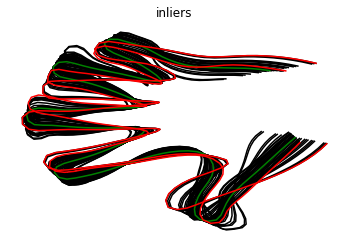

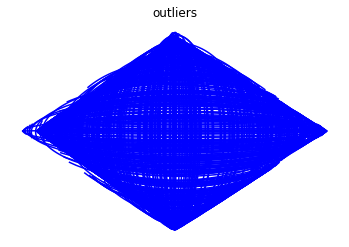

In [12]:

np.random.seed(1)

results = pd.DataFrame(columns = ['Num. Outliers','Algorithm', 'AUC'])
fl_type = [1,2]

#33 min to run

trial = 0

n_outs = 200

# load data
filepath = './Hands/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands0 = np.array(segmentationlist).T
hands = procrustes_hand(hands0)

hands1 = []
for h in hands:
    k_shape = unmake_1d(h)
    k_shape = k_shape - np.mean(k_shape, axis = 0)
    k_shape = k_shape/np.linalg.norm(k_shape)
    hands1.append(k_shape)

###############################################
###############################################
#INLIERS


x = hands1[0]
ys = [hands1[7],hands1[9]] #,hands1[10], hands1[15], hands1[20]] #works with 7
shapes = []
for i in np.linspace(-1,1,40):
    idx = np.random.choice([0,1])
    v = manifold.log(x,ys[idx])
    inlier = manifold.exp(x, i*v)
    shapes.append(inlier)

plt.figure()
plt.title('inliers')
for z in shapes:
    interp_points = interp(z)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'k')


interp_points = interp(x)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'g')
interp_points = interp(ys[0])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
interp_points = interp(ys[1])
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")

###############################################
###############################################
#OUTLIERS

for i in range(n_outs):
    outlier = generate_ellipse_outlier(i)
    shapes.append(outlier)

plt.figure()
plt.title('outliers')
# for z in shapes[-n_outs:]:
for z in shapes[40:]:
    interp_points = interp(z)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'b')
    plt.axis("off")

labels  = [0]*40 + [1]*n_outs

###############################################
###############################################
    
# np.random.seed(123)
# x = generate_ellipse_outlier(0)
# for i in range(n_outs):
#     x = x - np.mean(x, axis = 0)
#     x = x/np.linalg.norm(x)
#     y = manifold.random_point()
#     v = manifold.log(x,y)
#     outlier = manifold.exp(x, .05*np.random.rand()*v) #.05
#     shapes.append(outlier)



# np.random.seed(0)
# for i in range(n_outs):
#     # x= unmake_1d(hands[np.random.choice(np.arange(11,40,8))])
#     x= unmake_1d(hands[35])
#     x = x - np.mean(x, axis = 0)
#     x = x/np.linalg.norm(x)
#     y = manifold.random_point()
#     v = manifold.log(x,y)
#     outlier = manifold.exp(x, .04*np.random.rand()*v) #.05
#     shapes.append(outlier)

# x = hands1[0]
# # ys = [hands1[7],hands1[9]]
# # ys = [hands1[9],hands1[10]]
# ys = [hands1[2],hands1[3]] #works with 7
# shapes = []
# for i in np.linspace(-1,1,n_outs):
#     idx = np.random.choice([0,1])
#     v = manifold.log(x,ys[idx])
#     outlier = manifold.exp(x, i*v)
#     shapes.append(outlier)


# np.random.seed(123)
# x = generate_ellipse_outlier1(0)
# for i in range(n_outs):
#     # x= unmake_1d(hands[np.random.choice(np.arange(11,40,8))])
      # x= unmake_1d(hands[35])
#     x = x - np.mean(x, axis = 0)
#     x = x/np.linalg.norm(x)
#     y = manifold.random_point()
#     v = manifold.log(x,y)
#     outlier = manifold.exp(x, .05*np.random.rand()*v) #.05
#     shapes.append(outlier)

# y = manifold.random_point()
# v = manifold.log(x,y)
# z = manifold.exp(x,.05*v)
# for i in range(n_outs):
#     y1 = manifold.random_point()
#     v1 = manifold.log(z,y1)
#     # x= unmake_1d(hands[np.random.choice(np.arange(11,40,8))])
#     outlier = manifold.exp(z, .1*(.5-np.random.rand()*v1)) #.05
#     shapes.append(outlier)
# labels = [0]*40 + [1]*n_outs

# for h in hands0[11:]:
#     k_shape = unmake_1d(h)
#     k_shape = k_shape - np.mean(k_shape, axis = 0)
#     k_shape = k_shape/np.linalg.norm(k_shape)
#     shapes.append(k_shape)
# labels = [0]*40 + [1]*len(hands0[11:])



(-45.598199778446705, 81.96673037370965, -37.23461057551535, 38.55990393200095)

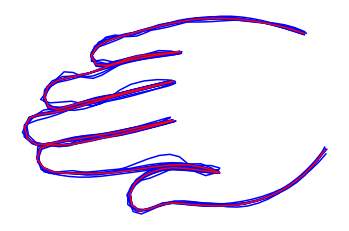

In [24]:
# np.random.seed(trial)
for i in range(10):
    # x= unmake_1d(hands[np.random.choice(np.arange(11,40,8))])
    x= unmake_1d(hands[35])
    x = x - np.mean(x, axis = 0)
    x = x/np.linalg.norm(x)
    y = manifold.random_point()
    v = manifold.log(x,y)
    outlier = manifold.exp(x, .04*np.random.rand()*v) #.05
    # outlier = manifold.exp(x, .02*np.random.normal(0,1)*v) #.05
    interp_points = interp(outlier)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'b')
    plt.axis("off")
interp_points = interp(x)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")


In [5]:
#DPCP-IRLS Code

def dpcp_irls(X: np.array, k: int, eps: float = 1e-10, delta: float = 1e-8, max_iter: int = 100):
    
    n_pts = X.shape[1]

    U,_,_ = np.linalg.svd(X)
    B0 = U[:,-k:]

    J = 0
    dJ = 1
    i = 0
    while i < max_iter and dJ > eps*J:
            
        J = np.sum(np.linalg.norm(X.T @ B0, axis = 1))
        
        wts = [np.sqrt(1/np.max([delta, np.linalg.norm(B0.T @ X[:,[i]])])) for i in range(n_pts)]
        W = np.diag(np.hstack(wts))

        U,_,_ = np.linalg.svd(X @ W)

        B = U[:,-k:]

        Bj = np.sum(np.linalg.norm(X.T @ B, axis = 1))

        dJ = J - Bj

        B0 = B
        i+= 1
    
    return B0

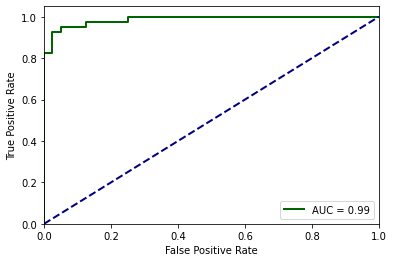

In [6]:

for n_shapes in [80]:#[60,80,100,120]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    #translate data to flattened tangent vectors at the mean
    t_data = []
    for i in range(len(shapes[:n_shapes])):
        t = manifold.log(median, shapes[:n_shapes][i]).flatten()
        t_data.append(t)
    


    #stack tangent vector data
    t_data = np.vstack(t_data).T

    Wbase = dpcp_irls(t_data, fl_type[-1])

    auc_val, dpcp2_preds, dpcp2_thresh  = run_roc(shapes[:n_shapes], Wbase, labels[:n_shapes], 'dpcp', 
                                                  manifold, t_data, median,do_plots = True )

--------------------
iteration 0
objective 0.00025230370146663266
flag distance between B0 and B1 0.214858456408346

--------------------
iteration 1
objective 0.00025230370146663266
flag distance between B0 and B1 2.5809568279517847e-08

--------------------
iteration 2
objective 0.00025230370146663266
flag distance between B0 and B1 2.5809568279517847e-08



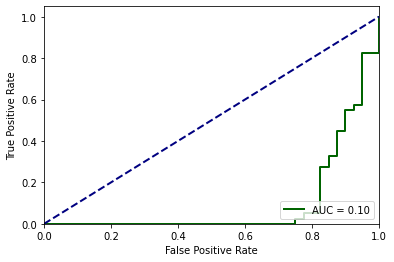

In [7]:
for n_shapes in [80]:#[60,80,100,120]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_d2ours,_,_], ts     = fdr.flag_robust_tpca(manifold, shapes[:n_shapes], 
                                                  fl_type = [fl_type[-1]], # changed this
                                                  pca_type = 'dpcp', 
                                                  return_ts = True,
                                                  median = median, init = 'rand', 
                                                  rand_seed = dr_seed, verbose = True )

    auc_val, dpcp2_preds, dpcp2_thresh  = run_roc(shapes[:n_shapes], W_d2ours, labels[:n_shapes], 'dpcp', 
                                                  manifold, ts, median,do_plots = True )

--------------------
iteration 0
objective 1.4288011721303065e-14
flag distance between B0 and B1 2.5809568279517847e-08

--------------------
iteration 1
objective 1.4288011721303065e-14
flag distance between B0 and B1 2.5809568279517847e-08

--------------------
iteration 2
objective 1.4288011721303065e-14
flag distance between B0 and B1 2.5809568279517847e-08



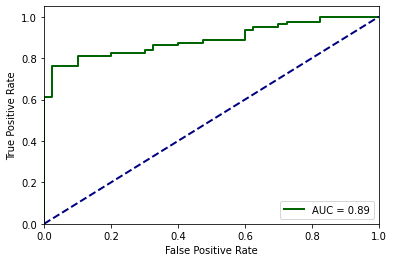

In [8]:
for n_shapes in [120]:#[60,80,100,120]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_d2ours,_,_], ts     = fdr.flag_robust_tpca(manifold, shapes[:n_shapes], 
                                                  fl_type = [fl_type[-1]], # changed this
                                                  pca_type = 'dpcp', 
                                                  return_ts = True,
                                                  median = median, init = 'svd', 
                                                  rand_seed = dr_seed, verbose = True )

    auc_val, dpcp2_preds, dpcp2_thresh  = run_roc(shapes[:n_shapes], W_d2ours, labels[:n_shapes], 'dpcp', 
                                                  manifold, ts, median,do_plots = True )

In [9]:
2 - np.trace(W_d2ours.T  @ Wbase @ Wbase.T @ W_d2ours)



1.976602140402521

In [10]:
U,_,_ = np.linalg.svd(ts)
B0 = U[:,-2:]

2 - np.trace(W_d2ours.T  @ Wbase @ Wbase.T @ W_d2ours)

1.976602140402521

In [26]:
for n_shapes in [100]:#[60,80,100,120]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_d2ours,_,_], ts     = fdr.flag_robust_tpca(manifold, shapes[:n_shapes], 
                                                  fl_type = fl_type, 
                                                  pca_type = 'dpcp', 
                                                  return_ts = True,
                                                  median = median, init = 'rand', 
                                                  rand_seed = dr_seed, verbose = True )

    auc_val, dpcp2_preds, dpcp2_thresh  = run_roc(shapes[:n_shapes], W_d2ours, labels[:n_shapes], 'dpcp', 
                                                  manifold, ts, median,do_plots = True )

KeyboardInterrupt: 

--------------------
iteration 0
objective 0.01929649868241894
flag distance between B0 and B1 1.4050731822436118

--------------------
iteration 1
objective 0.018872423069989125
flag distance between B0 and B1 0.0051336913565315926

--------------------
iteration 2
objective 0.01847147820664271
flag distance between B0 and B1 0.004877983332111679

--------------------
iteration 3
objective 0.018122045550294837
flag distance between B0 and B1 0.0042998457359758515

--------------------
iteration 4
objective 0.017843225525499922
flag distance between B0 and B1 0.003514018944502131

--------------------
iteration 5
objective 0.017843225525499922
flag distance between B0 and B1 2.9802322387695312e-08



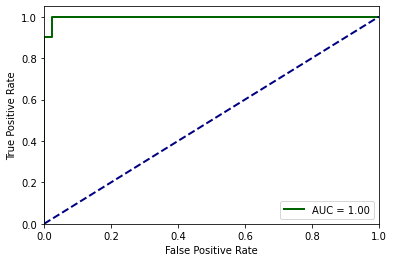

In [12]:
for n_shapes in [50]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_w2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes[:n_shapes], 
                                                  fl_type = [fl_type[-1]], 
                                                  pca_type = 'wpca', 
                                                  return_ts = True,
                                                 median = median, init = 'rand', 
                                                 rand_seed = dr_seed, verbose = True )

    auc_val, wpca2_preds, wpca2_thresh  = run_roc( shapes[:n_shapes], W_w2ours, labels[:n_shapes], 'wpca', manifold, ts,     median,do_plots = True )


--------------------
iteration 0
objective 1.7102734808764324
flag distance between B0 and B1 1.4051261025571136

--------------------
iteration 1
objective 1.7102763800416867
flag distance between B0 and B1 0.0049459073282818134

--------------------
iteration 2
objective 1.7102763800416867
flag distance between B0 and B1 2.9802322387695312e-08



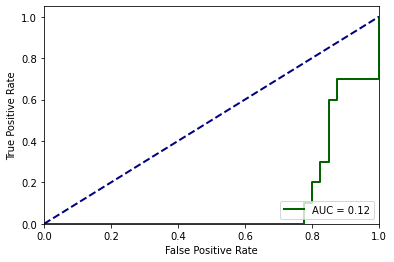

In [13]:
for n_shapes in [50]:
    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes[:n_shapes], seed = mean_seed)

    [W_w2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes[:n_shapes], 
                                                  fl_type = [fl_type[-1]], pca_type = 'rpca', 
                                                  return_ts = True, median = median, 
                                                  init = 'rand', rand_seed = dr_seed, 
                                                  verbose = True )

    auc_val, wpca2_preds, wpca2_thresh  = run_roc( shapes[:n_shapes], W_w2ours, labels[:n_shapes], 'rpca', manifold, ts,     median,do_plots = True )


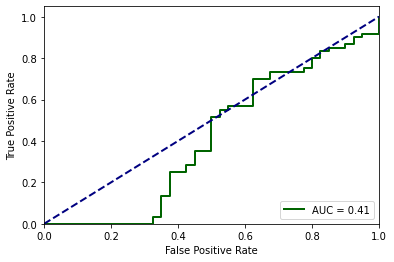

In [24]:
for n_shapes in [100]:
    W_pca, _, ts_pca, mean =   PGA0( manifold, shapes[:n_shapes], [fl_type[-1]], return_ts = True, eps = 1e-9 )

    auc_val, pca_preds, pca_thresh  = run_roc( shapes[:n_shapes], W_pca, labels[:n_shapes], 'pca', manifold, ts_pca, mean, do_plots = True )

(-38.600453450648104,
 43.339782412099076,
 -40.71519653575831,
 42.09806511035632)

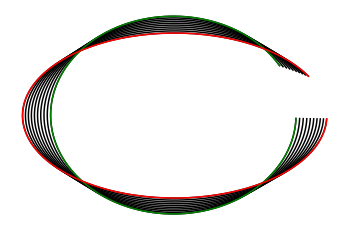

In [10]:

# x = shapes[0]
# y = shapes[7]

x = generate_ellipse_outlier1(0)
y = generate_ellipse_outlier1(1)
v = manifold.log(x,y)


for i in np.linspace(0,1,10):
    z = manifold.exp(x, i*v)
    interp_points = interp(z)
    plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'k')
    plt.axis("off")



interp_points = interp(x)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'g')
plt.axis("off")

interp_points = interp(y)
plt.plot(interp_points[0]*256,interp_points[1]*256, c = 'r')
plt.axis("off")